# 数据集结构

In [23]:
import numpy as np

tiktok_ds = "tiktok"

## 视觉&文本

In [2]:
image_feat = np.load(f"{tiktok_ds}/image_feat.npy")
text_feat = np.load(f"{tiktok_ds}/text_feat.npy")

In [3]:
print(f"image: {image_feat.shape}, text: {text_feat.shape}")

image: (6710, 128), text: (6710, 768)


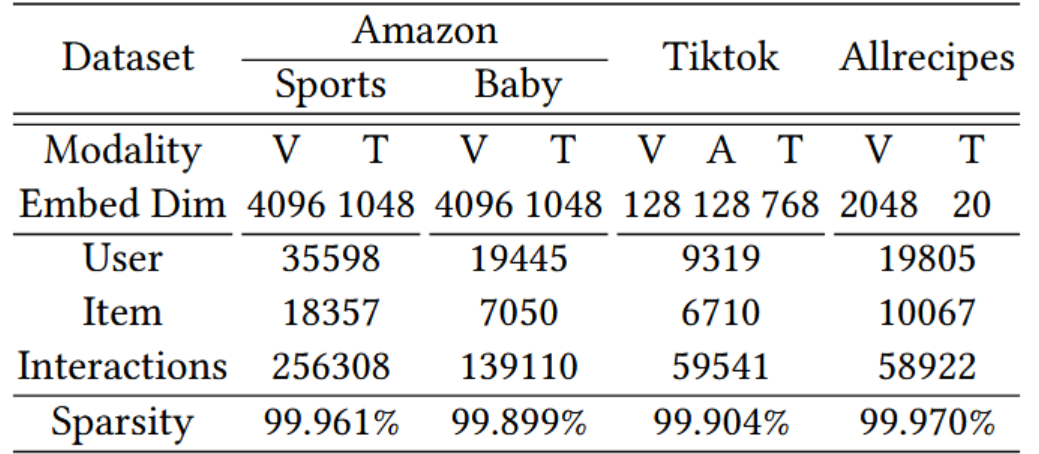

假设张量的 0 维跟用户相对应，那处理成 (num, dim) 即可兼容。

## 交互数据

In [5]:
import json
from dataclasses import dataclass

@dataclass
class Statistic:
    """数据集信息统计类"""
    user_num: int = 0
    item_num: int = 0
    interactions: int = 0
    user_without_items: int = 0
    sparsity: float = 0.

    def __str__(self) -> str:
        format_str = f"user: {self.user_num}, item: {self.item_num}\n"
        format_str += f"interactions: {self.interactions}\n"
        format_str += f"sparsity: {self.sparsity*100:.3f}%"
        return format_str

def cal_dataset(path):
    """计算数据集统计信息"""
    statistic = Statistic()
    with open(path, 'r') as file:
        data: dict[str, list[str]] = json.load(file)
    
    statistic.user_num = len(data)
    item_set = set()

    for _, items in data.items():
        if len(items) == 0:
            statistic.user_without_items += 1
            continue
        statistic.interactions += len(items)
        for item in items: item_set.add(item)
    
    statistic.item_num = len(item_set)
    statistic.sparsity = 1 - (statistic.interactions/(statistic.user_num*statistic.item_num))

    return statistic

In [11]:
train = cal_dataset(f"{tiktok_ds}/train.json")
value = cal_dataset(f"{tiktok_ds}/val.json")
test = cal_dataset(f"{tiktok_ds}/test.json")

In [10]:
print(train)

user: 9308, item: 6245
interactions: 59541
sparsity: 99.898%


这就很有意思了，训练集数据跟论文数据集统计数据完全一致，那评估/测试集哪来的？从训练集分出来的？那合着参赛选手当裁判？

In [24]:
import json

with open(f"{tiktok_ds}/train.json", 'r') as file:
    train_data = json.load(file)

In [25]:
print(len(train_data))

9308


In [27]:
for k,v in train_data.items():
    print(k, v)
    print(type(k), type(v))
    break

0 [885, 1387, 5424]
<class 'str'> <class 'list'>


也就是说交互数据是一个 dict，存储每个用户交互的项目列表 (**用户和项目都是编码后的**)

## mat 稀疏矩阵

~~不是，这玩意到底是个啥啊，scipy 和 h5py 都不能读啊~~

真牛逼啊，名字叫 mat，结果是 pickle 😅，我说怎么后缀都没有呢

In [16]:
import pickle

with open(f"{tiktok_ds}/train_mat", 'rb') as file:
    train_mat = pickle.load(file)

print(type(train_mat))
print(train_mat.shape)

<class 'scipy.sparse._csr.csr_matrix'>
(9319, 6710)


/tmp/ipykernel_50475/2545534195.py:4: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  train_mat = pickle.load(file)


所以这是一个全局的 U-I 交互图，不是二部图

In [18]:
print("Number of non-zero elements:", train_mat.nnz)

Number of non-zero elements: 59541


In [20]:
print(train_mat[0])

  (0, 885)	1.0
  (0, 1387)	1.0
  (0, 5424)	1.0


# 转换数据集结构

In [2]:
import os

ifashion_ds_mmssl = "ifashion_ds/mmssl"
os.makedirs(ifashion_ds_mmssl, exist_ok=True)

### 编码映射

入乡随俗，先构建用户和项目各自的映射表 (顺序无所谓，确保一一对应即可)

In [8]:
import os
import json

user2id: dict[str, int] = {}
item2id: dict[str, int] = {}

with open("ifashion_out/filter_interactions.txt", 'r') as file:
    for line in file:
        user, item, ratings = line.split(' ')
        if user not in user2id:
            user2id[user] = len(user2id)
        if item not in item2id:
            item2id[item] = len(item2id)

os.makedirs("ifashion_ds/remap", exist_ok=True)
with open("ifashion_ds/remap/user2id.json", 'w', encoding='utf-8') as f1:
    json.dump(user2id, f1, ensure_ascii=False)
with open("ifashion_ds/remap/item2id.json", 'w', encoding='utf-8') as f2:
    json.dump(item2id, f2, ensure_ascii=False)

In [9]:
with open("ifashion_ds/remap/user2id.json", 'r', encoding='utf-8') as f1:
    uid = json.load(f1)
print(len(uid))

with open("ifashion_ds/remap/item2id.json", 'r', encoding='utf-8') as f2:
    iid = json.load(f2)
print(len(iid))

38403
51939


## 处理 ifashion 交互数据

按照编码将交互数据处理为 json

In [17]:
import json
from collections import defaultdict

with open("ifashion_ds/remap/user2id.json", 'r', encoding='utf-8') as f1:
    user2id: dict[str, int] = json.load(f1)

with open("ifashion_ds/remap/item2id.json", 'r', encoding='utf-8') as f2:
    item2id: dict[str, int] = json.load(f2)

分别将各个数据集进行转换

In [28]:
def pre_save(interactions: dict[str, set]) -> dict[str, list[int]]:
    it_dict = {}
    for k,v in interactions.items():
        it_dict[k] = list(v)
    return it_dict

def ds_convert_json(txt_path: str, json_path: str, user2id: dict[str, int], item2id: dict[str, int]):
    out_json: dict[str, set] = defaultdict(set[int])
    with open(txt_path, 'r', encoding='utf-8') as f:
        for line in f:
            user, item, _ratings = line.split(' ')
            out_json[str(user2id[user])].add(item2id[item])
    
    with open(json_path, 'w', encoding='utf-8') as f:
        json.dump(pre_save(out_json), f, ensure_ascii=False)
    print(f"{txt_path} convert to {json_path}")

In [32]:
ds_convert_json(
    'ifashion_ds/train.txt',
    'ifashion_ds/mmssl/train.json',
    user2id, item2id
)

ifashion_ds/train.txt convert to ifashion_ds/mmssl/train.json


In [33]:
ds_convert_json(
    'ifashion_ds/val.txt',
    'ifashion_ds/mmssl/val.json',
    user2id, item2id
)

ifashion_ds/val.txt convert to ifashion_ds/mmssl/val.json


In [34]:
ds_convert_json(
    'ifashion_ds/test.txt',
    'ifashion_ds/mmssl/test.json',
    user2id, item2id
)

ifashion_ds/test.txt convert to ifashion_ds/mmssl/test.json


按照编码映射转换全局交互数据集

In [41]:
ds_convert_json(
    'ifashion_out/filter_interactions.txt',
    'ifashion_ds/remap/remap_ui_list.json',
    user2id, item2id
)

ifashion_out/filter_interactions.txt convert to ifashion_out/remap_ui_dict.json


### 构造 ifashion 稀疏矩阵

In [35]:
import json
from scipy.sparse import csr_matrix

def read_user_items(file_path):
    with open(file_path, 'r') as file:
        user_items = json.load(file)
    return user_items


def create_sparse_matrix(user_items: dict[str, list[int]]):
    # 获取用户和项目的最大编号
    max_user = max(map(int, user_items.keys()))
    max_item = max(max(items) for items in user_items.values())

    # 初始化稀疏矩阵
    rows = []
    cols = []
    data = []

    for user, items in user_items.items():
        user_id = int(user)
        for item_id in items:
            rows.append(user_id)
            cols.append(item_id)
            data.append(1.0)  # ratings设为1.0

    # 构造稀疏矩阵
    train_mat = csr_matrix((data, (rows, cols)), shape=(max_user + 1, max_item + 1))
    return train_mat

In [42]:
import pickle

user_items = read_user_items('ifashion_ds/remap/remap_ui_list.json')

# 构造稀疏矩阵
train_mat = create_sparse_matrix(user_items)

# 保存稀疏矩阵到文件
with open('ifashion_ds/mmssl/train_mat', 'wb') as file:
    pickle.dump(train_mat, file)

In [43]:
with open('ifashion_ds/mmssl/train_mat', 'rb') as file:
    matrix = pickle.load(file)
print(matrix.shape)

(38403, 51939)


## 处理 ifashion 多模态数据

说实话，我产生了跟这个老哥一样的[疑惑](https://github.com/HKUDS/MMSSL/issues/17)

所以首先：
1. image.safetensors 是 item -> image_embs
2. 构建 item -> item_id -> image_embs
3. 按照 item_id stack

但形状怎么确定？我处理得到的是全局特征，他这里是只需要训练集部分的数据吗吗？

In [4]:
import json
from safetensors.numpy import load_file
from tqdm import tqdm
import numpy as np

with open("ifashion_ds/remap/item2id.json", 'r', encoding='utf-8') as f2:
    item2id = json.load(f2)

image_id2embs: dict[str, np.ndarray] = {}
image_ndarrays = load_file("ifashion_ds/ifashion_image.safetensors")

for item in tqdm(image_ndarrays, desc='image embs'):
    image_id2embs[item2id[item]] = np.squeeze(image_ndarrays[item])

# 提取键并排序
sorted_keys = sorted(image_id2embs.keys(), key=int)
sorted_arrays = [image_id2embs[key] for key in sorted_keys]
result_array = np.stack(sorted_arrays, axis=0)  # (all_item_num, dim)

print(result_array.shape)
np.save('ifashion_ds/image_feat.npy', result_array)

image embs: 100%|██████████| 51939/51939 [00:00<00:00, 769033.47it/s]


(51939, 512)


文本特征

In [5]:
import json
from safetensors.numpy import load_file
from safetensors import safe_open
from tqdm import tqdm
import numpy as np

with open("ifashion_ds/remap/item2id.json", 'r', encoding='utf-8') as f2:
    item2id = json.load(f2)

text_id2embs: dict[str, np.ndarray] = {}
text_ndarrays = load_file("ifashion_ds/ifashion_text.safetensors")

for item in tqdm(text_ndarrays, desc='text embs'):
    text_id2embs[item2id[item]] = np.squeeze(text_ndarrays[item])

# 提取键并排序
sorted_keys = sorted(text_id2embs.keys(), key=int)
sorted_arrays = [text_id2embs[key] for key in sorted_keys]
result_array = np.stack(sorted_arrays, axis=0)  # (all_item_num, dim)

print(result_array.shape)
np.save('ifashion_ds/text_feat.npy', result_array)

text embs: 100%|██████████| 51939/51939 [00:00<00:00, 966713.66it/s]


(51939, 1024)


In [6]:
%%bash
rsync -avcP ifashion_ds/image_feat.npy ifashion_ds/text_feat.npy MMSSL/data/ifashion/

sending incremental file list
image_feat.npy
    106,371,200 100%  394.60MB/s    0:00:00 (xfr#1, to-chk=1/2)
text_feat.npy
    212,742,272 100%  263.83MB/s    0:00:00 (xfr#2, to-chk=0/2)

sent 319,191,586 bytes  received 54 bytes  212,794,426.67 bytes/sec
total size is 319,113,472  speedup is 1.00


显存遭不住，降维吧，全部降到128

In [3]:
import numpy as np
from sklearn.decomposition import PCA

# 加载数据
data = np.load('ifashion_ds/text_feat.npy')
# 初始化 PCA 模型，设置目标维度为 128
pca = PCA(n_components=128)
reduced_data = pca.fit_transform(data)
print("Reduced data shape:", reduced_data.shape)
np.save('ifashion_ds/text_feat_128.npy', reduced_data)

Reduced data shape: (51939, 128)


In [4]:
%%bash
rsync -avcP ifashion_ds/image_feat_128.npy MMSSL/data/ifashion/image_feat.npy
rsync -avcP ifashion_ds/text_feat_128.npy MMSSL/data/ifashion/text_feat.npy

sending incremental file list
image_feat_128.npy
     26,592,896 100%  402.06MB/s    0:00:00 (xfr#1, to-chk=0/1)

sent 26,599,510 bytes  received 35 bytes  53,199,090.00 bytes/sec
total size is 26,592,896  speedup is 1.00
sending incremental file list
text_feat_128.npy
     26,592,896 100%  402.06MB/s    0:00:00 (xfr#1, to-chk=0/1)

sent 26,599,509 bytes  received 35 bytes  53,199,088.00 bytes/sec
total size is 26,592,896  speedup is 1.00


In [5]:
%%bash
rsync -avcP ifashion_ds/image_feat_128.npy LATTICE/codes/data/ifashion/image_feat.npy
rsync -avcP ifashion_ds/text_feat_128.npy LATTICE/codes/data/ifashion/text_feat.npy

sending incremental file list
image_feat_128.npy
     26,592,896 100%  395.78MB/s    0:00:00 (xfr#1, to-chk=0/1)

sent 26,599,510 bytes  received 35 bytes  53,199,090.00 bytes/sec
total size is 26,592,896  speedup is 1.00
sending incremental file list
text_feat_128.npy
     26,592,896 100%  395.78MB/s    0:00:00 (xfr#1, to-chk=0/1)

sent 26,599,509 bytes  received 35 bytes  53,199,088.00 bytes/sec
total size is 26,592,896  speedup is 1.00
